In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os 

# 0. 准备工作：设置设备 (GPU or CPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. 定义数据预处理
# MindSpore文档中提到了随机裁剪、随机翻转、归一化等操作
# 训练集的预处理：增加数据增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # 随机裁剪
    transforms.RandomHorizontalFlip(),         # 随机水平翻转
    transforms.ToTensor(),                     # 转换为Tensor，并将像素值缩放到[0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # 标准化
])

# 测试集的预处理：不需要数据增强
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. 加载CIFAR-10数据集
# torchvision会自动下载数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 3. 创建数据加载器 (DataLoader)
batch_size = 32 # 文档中也使用了32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 4. 定义类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


## 数据可视化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


horse frog  bird  bird  truck cat   ship  plane horse deer  plane frog  plane dog   horse bird  cat   bird  horse bird  car   truck ship  deer  frog  truck plane ship  dog   horse plane cat  


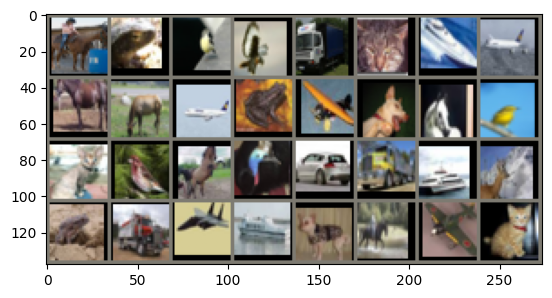

In [19]:
def imshow(img):
    # 反标准化
    img[0] = img[0] * 0.2023 + 0.4914
    img[1] = img[1] * 0.1994 + 0.4822
    img[2] = img[2] * 0.2010 + 0.4465
    npimg = img.numpy()
    # matplotlib需要维度是 [H, W, C]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 获取一些随机的训练图像
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图像
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
imshow(torchvision.utils.make_grid(images))

In [20]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 对应文档中的conv1，输入3通道，输出6通道，5x5卷积核
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 对应文档中的conv2，输入6通道，输出16通道，5x5卷积核
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        # 对应文档中的fc1。输入维度计算：
        # 初始: 32x32 -> conv1 -> 28x28 -> pool -> 14x14
        # -> conv2 -> 10x10 -> pool -> 5x5。所以是 16*5*5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 对应文档中的fc2
        self.fc2 = nn.Linear(120, 84)
        # 对应文档中的fc3 (输出层)，输出10个类别
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # 展平操作
        x = torch.flatten(x, 1) # 从维度1开始展平
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 实例化模型并移动到指定设备
net = LeNet5().to(device)
print(net)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 步骤 4 & 5: 定义损失函数、优化器，并训练测试模型
对应文档 2.5.5 节。PyTorch中没有像MindSpore那样高度封装的Model.train()接口，我们需要自己编写训练循环，但这能让我们更好地控制训练过程。

In [21]:
# 1. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss() # PyTorch的CrossEntropyLoss已包含Softmax
optimizer = optim.Adam(net.parameters(), lr=0.001) # 与文档一致使用Adam

# 2. 训练函数
def train(epoch, net, trainloader,optimizer):
    print(f'\nEpoch: {epoch + 1}')
    net.train() # 设置为训练模式
    train_loss = 0
    correct = 0
    total = 0
    batch_idx=0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 清空梯度
        outputs = net(inputs) # 前向传播
        loss = criterion(outputs, targets) # 计算损失
        loss.backward() # 反向传播
        optimizer.step() # 更新权重

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f'Epoch {epoch+1} | Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')

# 3. 测试函数
def test(net, testloader):
    net.eval() # 设置为评估模式
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # 在评估时不计算梯度
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    print(f'Test Results | Loss: {test_loss/len(testloader):.3f} | Acc: {acc:.3f}% ({correct}/{total})')
    return acc

# 4. 执行训练和测试
num_epochs = 10 # 先训练10个epoch看效果
for epoch in range(num_epochs):
    train(epoch, net, trainloader,optimizer)
    test(net, testloader)


Epoch: 1
Epoch 1 | Loss: 1.698 | Acc: 37.312% (18656/50000)
Test Results | Loss: 1.434 | Acc: 48.470% (4847/10000)

Epoch: 2
Epoch 2 | Loss: 1.438 | Acc: 47.948% (23974/50000)
Test Results | Loss: 1.322 | Acc: 52.030% (5203/10000)

Epoch: 3
Epoch 3 | Loss: 1.339 | Acc: 51.590% (25795/50000)
Test Results | Loss: 1.192 | Acc: 57.580% (5758/10000)

Epoch: 4
Epoch 4 | Loss: 1.265 | Acc: 54.664% (27332/50000)
Test Results | Loss: 1.152 | Acc: 58.970% (5897/10000)

Epoch: 5
Epoch 5 | Loss: 1.217 | Acc: 56.538% (28269/50000)
Test Results | Loss: 1.118 | Acc: 60.700% (6070/10000)

Epoch: 6
Epoch 6 | Loss: 1.182 | Acc: 57.754% (28877/50000)
Test Results | Loss: 1.120 | Acc: 60.370% (6037/10000)

Epoch: 7
Epoch 7 | Loss: 1.155 | Acc: 59.144% (29572/50000)
Test Results | Loss: 1.080 | Acc: 62.210% (6221/10000)

Epoch: 8
Epoch 8 | Loss: 1.138 | Acc: 59.610% (29805/50000)
Test Results | Loss: 1.079 | Acc: 61.740% (6174/10000)

Epoch: 9
Epoch 9 | Loss: 1.122 | Acc: 60.166% (30083/50000)
Test Result

In [23]:
class LeNet5_Optimized(nn.Module):
    def __init__(self):
        super(LeNet5_Optimized, self).__init__()
        # 结构：Conv-BN-ReLU -> Conv-BN-ReLU -> Pool
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # 结构：Conv-BN-ReLU -> Conv-BN-ReLU -> Pool
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # 初始: 32x32 -> pool1 -> 16x16 -> pool2 -> 8x8。所以是 128*8*8
        self.fc_block = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = torch.flatten(x, 1)
        x = self.fc_block(x)
        return x
# 实例化新模型
optimized_net = LeNet5_Optimized().to(device)
optimizer_opt = optim.Adam(optimized_net.parameters(), lr=0.001)
# 重新执行训练和测试
num_epochs_opt = 100 # 训练更多轮次
for epoch in range(num_epochs_opt):
    # 需要修改train和test函数，让它们接受optimizer作为参数
    # 这里为了简洁，直接使用新的optimizer
    train(epoch, optimized_net, trainloader, optimizer_opt) # 你需要重写train函数或重新定义optimizer
    test(optimized_net, testloader) 

Epoch 1 | Loss: 1.428 | Acc: 47.744% (23872/50000)
Test Results | Loss: 1.080 | Acc: 62.030% (6203/10000)

Epoch: 2
Epoch 2 | Loss: 1.003 | Acc: 64.258% (32129/50000)
Test Results | Loss: 0.816 | Acc: 70.820% (7082/10000)

Epoch: 3
Epoch 3 | Loss: 0.849 | Acc: 69.916% (34958/50000)
Test Results | Loss: 0.884 | Acc: 69.790% (6979/10000)

Epoch: 4
Epoch 4 | Loss: 0.761 | Acc: 73.344% (36672/50000)
Test Results | Loss: 0.713 | Acc: 75.500% (7550/10000)

Epoch: 5
Epoch 5 | Loss: 0.700 | Acc: 75.440% (37720/50000)
Test Results | Loss: 0.688 | Acc: 76.270% (7627/10000)

Epoch: 6
Epoch 6 | Loss: 0.633 | Acc: 77.972% (38986/50000)
Test Results | Loss: 0.678 | Acc: 77.370% (7737/10000)

Epoch: 7
Epoch 7 | Loss: 0.594 | Acc: 79.504% (39752/50000)
Test Results | Loss: 0.566 | Acc: 80.630% (8063/10000)

Epoch: 8
Epoch 8 | Loss: 0.553 | Acc: 80.792% (40396/50000)
Test Results | Loss: 0.567 | Acc: 81.340% (8134/10000)

Epoch: 9
Epoch 9 | Loss: 0.523 | Acc: 81.930% (40965/50000)
Test Results | Loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.827451].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


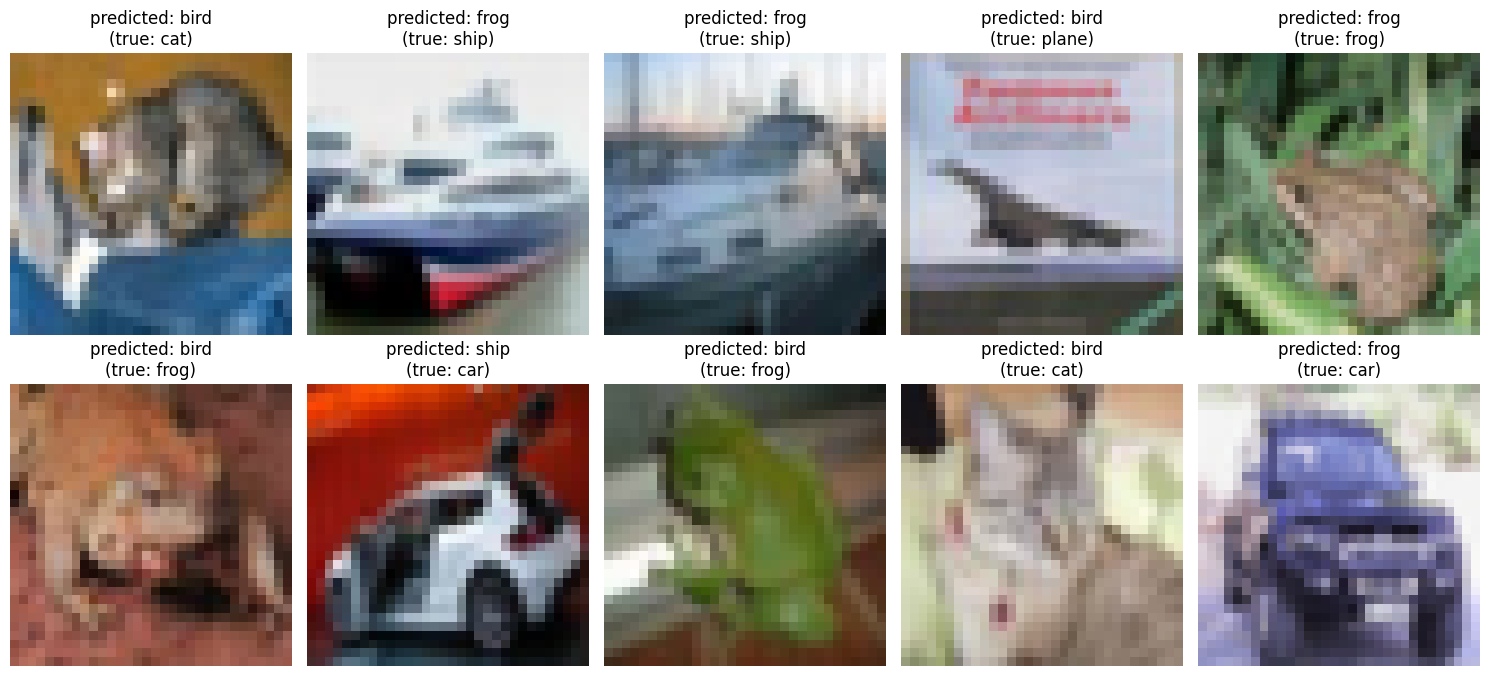

In [ ]:
def visualize_predictions(net, loader, num_images=10):
    net.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 7))
    with torch.no_grad():
        # 从测试数据加载器中获取一个批次
        dataiter = iter(loader)
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if images_so_far >= num_images:
                break
            images_so_far += 1
            ax = plt.subplot(num_images // 5, 5, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {classes[preds[i]]}\n(true: {classes[labels[i]]})')
            # 反标准化并显示图像
            img = images[i].cpu()
            img[0] = img[0] * 0.2023 + 0.4914
            img[1] = img[1] * 0.1994 + 0.4822
            img[2] = img[2] * 0.2010 + 0.4465
            npimg = img.numpy()
            plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.tight_layout()
        plt.show()
# 使用训练好的优化模型进行可视化
visualize_predictions(optimized_net, testloader)